In [185]:
'''
Ref:Multi-Class Text Classification with Scikit-Learn
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import random
import string
import html
import re
import pickle

from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.exceptions import NotFittedError

# read file structure and get features and labels(df_paths)

In [186]:
root_dir = '/Users/wentingchen/Documents/Folder_Sophie/' # '/' in the end!!!
data = []
for filename in glob.iglob(root_dir + '**/*', recursive=True):
     data.append(os.path.relpath(filename, root_dir))  
        

In [187]:
random.sample(data,100)

['Research/Hg/Hg-references/Hg_Dimer_states/JPB_1986_Laser-induced fluorescence spectrum arising from G0u+-X0g+ bound-free transitions in Hg2.pdf',
 'CS/Udacity/DS_Nanodegree/DSND_Term1-master/lessons/DeepLearning/3_PyTorch/assets/dog.128.jpg',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/248nmPumped/11-2015V2/195C/335-5.csv',
 'Research/Hg/HgData_Processing/Hg-two-color-pump/10-05-2016/410-411nm/data1_4.lvm',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/266nmPumped/05-27-2015/average 256 times/600c-335.csv',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/248nmPumped/11-2015V2/229C/271-15.csv',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/248nmPumped/11-10-2015/348C/271-5.csv',
 'Research/XeI/XeI_SpectralSimulations/XeI_code_wendy/old_codes/gen_mommatrix.m',
 'Research/Hg/HgData_Processing/HgCellwithVaccum/266nmPumped/05-01-2015-Hg data-266 pumped/500c-5s/Spreadsheet_050115151649.xls',
 'CS/Insight/ai-download-manager/Sophie_AI_download_manager/older/flask_part/flaskexamp

In [4]:
# file_names_txt = 'file-path-classifier-data.txt'
# file = open(file_names_txt,'r') 

# data = file.read().split('\n')

In [5]:
data_split = list(map(lambda x: os.path.normpath(x).split(os.sep), data))
data_drop_single = list(filter(lambda x: len(x)>1, data_split)) #change to len(x)>1 since solver needs >=2 classes!!!!

# file name engineering
file_name = list(map(lambda x: x[-1], data_drop_single))

file_name_html = [html.unescape(x) for x in file_name]
file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
ps = PorterStemmer()
word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]

word_stemmed_list = [list(x) for x in word_stemmed]
file_name_final = [' '.join(x) for x in word_stemmed_list]        

# file labels engineering
file_labels = list(map(lambda x: x[:-1], data_drop_single))
df_labels = pd.DataFrame(data = file_labels)
df_paths = pd.DataFrame(data = df_labels[0])
for i in range(1, df_labels.shape[1]):
    df_paths[i] = df_labels[i]

    df_paths.loc[pd.notna(df_labels[i]), i] = df_paths[i-1].map(str) + '/' + df_paths[i]
    
df_paths.replace('None', np.nan, inplace=True)
df_paths[-1] = 'dummy'
df_paths = df_paths.astype('category', copy = False)

In [6]:
random.sample(file_name,20)

['data_23.lvm',
 'data1_58.lvm',
 'data_367.lvm',
 '8_2g.angstrom.unscaled.csv',
 '485-5.csv',
 '298C',
 'data_431.lvm',
 '485nm-4.csv',
 'yag_laser_manual-continuum.pdf',
 'charseq.jpeg',
 'data_220.lvm',
 '335nm-200uj-2.csv',
 '335-4.csv',
 'apstemplateNotes.bib',
 'NRS 1994 Molecular beam spectroscopy of the  and  transitions in Hg2.pdf',
 'test_1328.lvm',
 'zn222.mat',
 'IMAGE_011415113600.png',
 'spectra17800.png',
 'data_611.lvm']

# file name engineering

In [180]:
def file_name_processing(file_name):
    

    file_name_html = [html.unescape(x) for x in file_name]
    print(file_name_html)
    file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
    print(file_name_underscore)
    file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
    print(file_name_word_split)
    ps = PorterStemmer()
    word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]
    word_stemmed_list = [list(x) for x in word_stemmed]
    
    print(word_stemmed_list)
    file_name_final = [' '.join(x) for x in word_stemmed_list]    
    print(file_name_final)
    
    count_vect = pickle.load(open('count_vect', 'rb'))

    file_name_vect = count_vect.transform(file_name_final)
    
    print(file_name_vect)
    
#     print(count_vect.get_feature_names())
#     print(count_vect.get_stop_words())

In [181]:
name_example=['CP 2006 Theoretical potential energy surfaces for excited mercury trimers.pdf']
file_name_processing(name_example)

['CP 2006 Theoretical potential energy surfaces for excited mercury trimers.pdf']
['cp 2006 theoretical potential energy surfaces for excited mercury trimers.pdf']
[['cp', '2006', 'theoretical', 'potential', 'energy', 'surfaces', 'for', 'excited', 'mercury', 'trimers', 'pdf']]
[['cp', '2006', 'theoret', 'potenti', 'energi', 'surfac', 'for', 'excit', 'mercuri', 'trimer', 'pdf']]
['cp 2006 theoret potenti energi surfac for excit mercuri trimer pdf']
  (0, 145)	1
  (0, 568)	1
  (0, 709)	1
  (0, 721)	1
  (0, 722)	1
  (0, 868)	1
  (0, 933)	1
  (0, 947)	1
  (0, 948)	1
  (0, 1042)	1
  (0, 1078)	1


In [9]:
name_example=['JPD 2006 Optical emission studies of the mercury plasma generated by the fundamental, second and third harmonics of a Nd  YAG laser.pdf']

file_name_processing(name_example)

['JPD 2006 Optical emission studies of the mercury plasma generated by the fundamental, second and third harmonics of a Nd \u2009YAG laser.pdf']
['jpd 2006 optical emission studies of the mercury plasma generated by the fundamental, second and third harmonics of a nd \u2009yag laser.pdf']
[['jpd', '2006', 'optical', 'emission', 'studies', 'of', 'the', 'mercury', 'plasma', 'generated', 'by', 'the', 'fundamental', 'second', 'and', 'third', 'harmonics', 'of', 'a', 'nd', 'yag', 'laser', 'pdf']]
[['jpd', '2006', 'optic', 'emiss', 'studi', 'of', 'the', 'mercuri', 'plasma', 'gener', 'by', 'the', 'fundament', 'second', 'and', 'third', 'harmon', 'of', 'a', 'nd', 'yag', 'laser', 'pdf']]
['jpd 2006 optic emiss studi of the mercuri plasma gener by the fundament second and third harmon of a nd yag laser pdf']
  (0, 145)	1
  (0, 705)	1
  (0, 746)	1
  (0, 751)	1
  (0, 838)	1
  (0, 868)	1
  (0, 913)	1
  (0, 933)	1
  (0, 1026)	1
  (0, 1136)	1
['00', '01', '02', '02 11', '03', '04', '05', '052703', '052

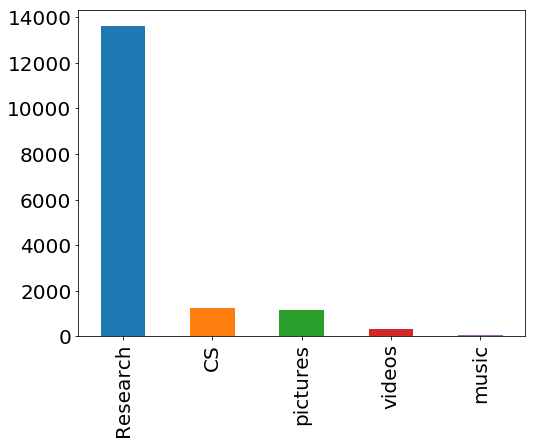

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_paths[0].value_counts().plot.bar(ylim=0)
plt.tick_params(which='major', labelsize=20)
plt.show()

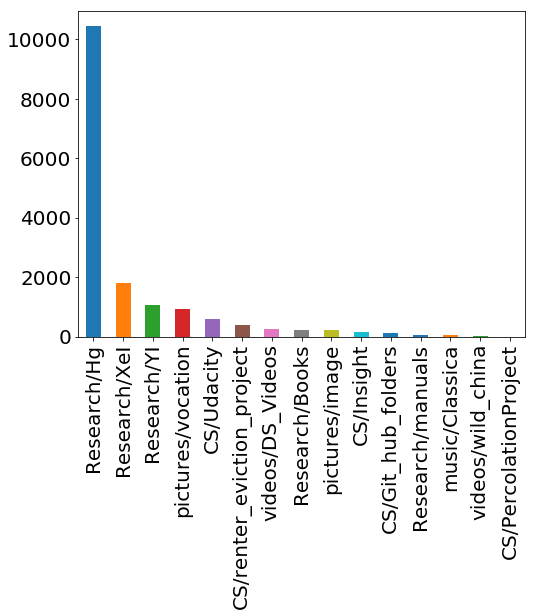

In [11]:
fig = plt.figure(figsize=(8,6))
df_paths.loc[:,1].value_counts().plot.bar(ylim=0)
plt.tick_params(which='major', labelsize=20)
plt.show()

In [35]:
df_paths[0].value_counts()


Research    13632
CS           1262
pictures     1150
videos        307
music          51
Name: 0, dtype: int64

In [36]:
type(_)

pandas.core.series.Series

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119919358>],
      dtype=object)

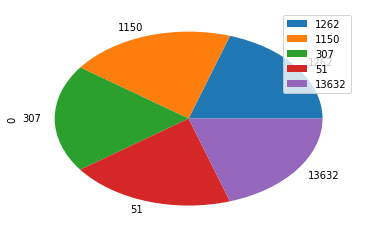

In [47]:
df_1_level = pd.DataFrame(data = df_paths[0].value_counts())

df_1_level.apply(pd.value_counts).plot(kind='pie', subplots=True)

In [49]:
df_paths[0].value_counts().tolist()

[13632, 1262, 1150, 307, 51]

In [52]:
df_paths[0].value_counts().index

CategoricalIndex(['Research', 'CS', 'pictures', 'videos', 'music'], categories=['CS', 'Research', 'music', 'pictures', 'videos'], ordered=False, dtype='category')

# Pie Chart

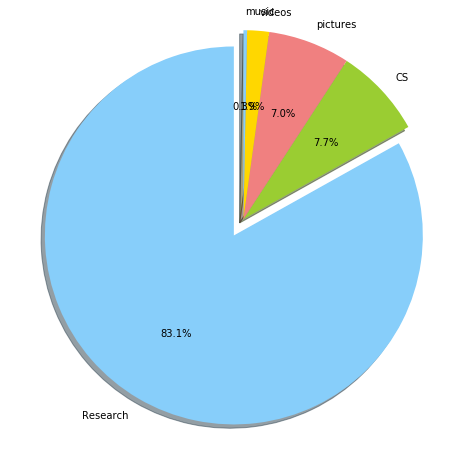

In [60]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Research', 'CS', 'pictures', 'videos', 'music'
sizes = [13632, 1262, 1150, 307, 51]
colors = ['lightskyblue', 'yellowgreen', 'lightcoral', 'gold']
explode = (0.1, 0, 0, 0,0)  # explode 1st slice
 
# Plot
fig = plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
 
plt.axis('equal')

plt.show()

# Train the model

In [12]:
def Hierarchical_train(file_name_final, df_paths):
    
    count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
                    ngram_range=(1, 2), stop_words='english')

    X_train_counts = count_vect.fit_transform(file_name_final)
    features = X_train_counts.toarray()
    
# works better without tf-idf
#     tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

#     X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#     features = X_train_tfidf.toarray()


    depth = df_paths.shape[1]
    folder_each_level = [df_paths[x].cat.categories.tolist() for x in range(-1,df_paths.shape[1]-1)]



    clf = [[LogisticRegression(random_state = 0) for _ in range(len(folder_each_level[x]))] \
           for x in range(len(folder_each_level))]

    for i in range(len(folder_each_level)-1):
        for j in range(len(folder_each_level[i])):

            # input control
            ind = ((df_paths[i-1] == folder_each_level[i][j]) & (df_paths[i].notna())) # remove NAN paths at the same time          

            # category / labels control: next col of df_paths
            features_level = features[ind] # just pick the corresponding entries
            labels_level = np.asarray(df_paths[i][ind], dtype="str")
            
            if len(np.unique(labels_level)) > 1 and len(labels_level)>5:
                clf[i][j] = LogisticRegression(random_state = 0)
                clf[i][j].fit(features_level, labels_level)
    
    pickle.dump(clf, open('clf_folder_picker', 'wb'))
    pickle.dump(count_vect, open('count_vect', 'wb'))
    pickle.dump(folder_each_level, open('folder_each_level', 'wb'))


# Predict

In [13]:
def Hierarchical_predict(file_names_input, prob_threshold):
    # file_names_input should be an array
#     clf = clf
#     count_vect = count_vect
    
    prob_threshold = prob_threshold
    
    
    clf = pickle.load(open('clf_folder_picker', 'rb'))
    
    
    count_vect = pickle.load(open('count_vect', 'rb'))
    folder_each_level = pickle.load(open('folder_each_level', 'rb'))
    
    
    file_name_html = [html.unescape(x) for x in file_names_input]
    file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
    file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
    ps = PorterStemmer()
    word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]

    word_stemmed_list = [list(x) for x in word_stemmed]
    file_name_final = [' '.join(x) for x in word_stemmed_list]   
    
    
    

    preds = []
    for file_name_input in file_name_final:
        
        vect_name = count_vect.transform([file_name_input])
        y_pred =  ['' for _ in range(len(folder_each_level)-1)]
        prob = [0 for _ in range(len(folder_each_level)-1)]
        prob_total = 1

        current_folder = 'dummy'
        for i in range(len(folder_each_level)-1):
            for j in range(len(folder_each_level[i])):
#                 print(i,j)

                if current_folder != folder_each_level[i][j]: #make sure it is the right subfolder
                    continue

#                 print('folder_each_level:',folder_each_level[i][j])
#                 print('current_folder:', current_folder)

                try:
                    clf[i][j].predict(vect_name)
                except NotFittedError as e:
                    #print('error')
                    break
                    
                y_pred[i] = clf[i][j].predict(vect_name)[0]
                current_folder = y_pred[i]
                prob[i] = np.max(clf[i][j].predict_proba(vect_name))
                prob_total *= prob[i]

#                     print(y_pred[i], prob[i], prob_total,'\n')


    
            if prob_total < prob_threshold or y_pred[i] == '':
                break
       
        # if i > 0 and back up a level if prob_total < prob_threshold:
        if (i > 0) and ((prob_total < prob_threshold) or (y_pred[i] == '')):
            pred_folder = y_pred[i-1] 
            level = i
        else:
            pred_folder = y_pred[i]
            level = i+1
        
        # when there is no pretrained clf available at this level
        if pred_folder == '':
            #print(i, j, current_folder,'\n', y_pred[i-2], y_pred[i-1])
            pred_folder = current_folder
        preds.append((pred_folder, level))
        
        
    return preds
    

In [14]:
def Hierarchical_predict_non_accum(file_names_input, prob_threshold):
    # file_names_input should be an array
#     clf = clf
#     count_vect = count_vect
    
    prob_threshold = prob_threshold
    
    
    clf = pickle.load(open('clf_folder_picker', 'rb'))
    
    
    count_vect = pickle.load(open('count_vect', 'rb'))
    folder_each_level = pickle.load(open('folder_each_level', 'rb'))
    
    
    file_name_html = [html.unescape(x) for x in file_names_input]
    file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
    file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
    ps = PorterStemmer()
    word_stemmed = [(ps.stem(y) for y in x) for x in file_name_word_split]

    word_stemmed_list = [list(x) for x in word_stemmed]
    file_name_final = [' '.join(x) for x in word_stemmed_list]   
    
    
    

    preds = []
    for file_name_input in file_name_final:
        
        vect_name = count_vect.transform([file_name_input])
        y_pred =  ['' for _ in range(len(folder_each_level)-1)]
        prob = [0 for _ in range(len(folder_each_level)-1)]
        prob_total = 1

        current_folder = 'dummy'
        for i in range(len(folder_each_level)-1):
            for j in range(len(folder_each_level[i])):
#                 print(i,j)

                if current_folder != folder_each_level[i][j]: #make sure it is the right subfolder
                    continue

#                 print('folder_each_level:',folder_each_level[i][j])
#                 print('current_folder:', current_folder)

                try:
                    clf[i][j].predict(vect_name)
                except NotFittedError as e:
                    #print('error')
                    break
                    
                y_pred[i] = clf[i][j].predict(vect_name)[0]
                current_folder = y_pred[i]
                prob[i] = np.max(clf[i][j].predict_proba(vect_name))
                
                #change prob_total to prob[i] for non accumulated version!!!!!!!
                prob_total = prob[i]

#                     print(y_pred[i], prob[i], prob_total,'\n')


    
            if prob_total < prob_threshold or y_pred[i] == '':
                break
       
        # if i > 0 and back up a level if prob_total < prob_threshold:
        if (i > 0) and ((prob_total < prob_threshold) or (y_pred[i] == '')):
            pred_folder = y_pred[i-1] 
            level = i
        else:
            pred_folder = y_pred[i]
            level = i+1
        
        # when there is no pretrained clf available at this level
        if pred_folder == '':
            #print(i, j, current_folder,'\n', y_pred[i-2], y_pred[i-1])
            pred_folder = current_folder
        preds.append((pred_folder, level))
        
        
    return preds
    

In [15]:
df_paths.shape[1]

10

# Evaluation


## same path, not necessarily same folder

In [16]:
from collections import defaultdict

def Hierarchical_auc(pred_folder, df_paths):
    count_total = len(pred_folder)
    count_right_path = 0
    count_right_level = 0
    #count_close_level = 0
    
    level_diff_max = df_paths.shape[1] - 1
    count_diff = [0 for _ in range(level_diff_max)]
    
    file_folder_labels = pd.DataFrame(data = df_paths.count(axis=1)-1, columns=['level'])
    file_folder_labels['labels'] = [set(df_paths.iloc[x,:]) for x in range(df_paths.shape[0])]

    d = defaultdict(int)

    for i in range(count_total):
        if pred_folder[i][0] in file_folder_labels.iloc[i, 1]:
            count_right_path +=1
            d[pred_folder[i][1]] += 1
            
            if pred_folder[i][1] == file_folder_labels.iloc[i, 0]:
                count_right_level +=1
                
            for j in range(level_diff_max):
                if j == 0 :
                    if pred_folder[i][1] == file_folder_labels.iloc[i, 0]:
                        count_diff[j] +=1
                else:
                    if pred_folder[i][1] == file_folder_labels.iloc[i, 0]-j:# \or pred_folder[i][1] == file_folder_labels.iloc[i, 0]+j:
                        count_diff[j] +=1
                
            
            
                


    b = defaultdict(int)
    for i in d.keys():
        b[i] = round(d[i]/count_total,3)
    print(b.items())
    
    count_list = [count_right_path/count_total, count_right_level/count_total]
    count_ratio = [round(x,3) for x in count_list]
    print('Ratio of count_right_path', 'Ratio of count_right_level', count_ratio)

    
    print('\n',[round(x/count_total,3) for x in count_diff])
#     return b.items()
    

In [17]:
df_paths.shape

(16402, 10)

## train split data, vectorize features

In [18]:
X_train, X_test, y_train, y_test = train_test_split(file_name_final, df_paths, \
                                                    test_size=0.1, random_state = 42)

## train predict compare acccuracy

In [19]:
Hierarchical_train(X_train, y_train)

In [20]:
prob_threshold = 0.9
preds = Hierarchical_predict(X_train, prob_threshold)

In [21]:
Hierarchical_auc(preds, y_train)

dict_items([(4, 0.248), (5, 0.181), (2, 0.076), (1, 0.28), (3, 0.064)])

 [0.035, 0.077, 0.439, 0.108, 0.081, 0.071, 0.031, 0.005, 0.002]


In [22]:
from functools import reduce
reduce((lambda x, y: x + y), [0.244, 0.152, 0.138, 0.127, 0.086, 0.07, 0.068, 0.028, 0.003])

0.916

In [23]:
reduce((lambda x, y: x + y), [0.086, 0.07, 0.068, 0.028,0.003])

0.255

In [24]:
preds[0][0]

'Research/Hg/HgData_Processing/Hg-two-color-pump'

In [25]:
# for i, pred in enumerate(preds):
#     print(pred)
#     #print(X_train[i],'\n')

In [26]:
preds_test = Hierarchical_predict(X_test, prob_threshold)

Hierarchical_auc(preds_test, y_test)

dict_items([(1, 0.282), (2, 0.079), (5, 0.183), (4, 0.24), (3, 0.052)])

 [0.035, 0.066, 0.445, 0.102, 0.08, 0.064, 0.037, 0.007, 0.001]


# accumulated prob_total version

# right path & folder rate

In [27]:
# accumulated prob_total version 

for prob_threshold in np.linspace(0,1,11):
    print(prob_threshold)
    print('train_set:')
    preds = Hierarchical_predict(X_train, prob_threshold)

    Hierarchical_auc(preds, y_train)
    print('\n')
    print('test_set')
    preds_test = Hierarchical_predict(X_test,prob_threshold)

    Hierarchical_auc(preds_test, y_test)
    print('\n\n')

0.0
train_set:
dict_items([(1, 0.003), (3, 0.046), (4, 0.026), (5, 0.071), (6, 0.035), (2, 0.012), (7, 0.001)])

 [0.114, 0.067, 0.005, 0.004, 0.003, 0.0, 0.001, 0.0, 0.0]


test_set
dict_items([(3, 0.043), (4, 0.024), (2, 0.014), (5, 0.066), (1, 0.003), (6, 0.027), (7, 0.002)])

 [0.099, 0.068, 0.007, 0.004, 0.002, 0.0, 0.001, 0.0, 0.0]



0.1
train_set:
dict_items([(1, 0.003), (3, 0.062), (5, 0.089), (6, 0.034), (4, 0.032), (2, 0.013), (7, 0.001)])

 [0.122, 0.086, 0.015, 0.006, 0.004, 0.0, 0.001, 0.0, 0.0]


test_set
dict_items([(3, 0.064), (4, 0.035), (2, 0.015), (5, 0.084), (1, 0.003), (6, 0.026)])

 [0.104, 0.091, 0.021, 0.007, 0.003, 0.0, 0.001, 0.0, 0.0]



0.2
train_set:
dict_items([(5, 0.135), (1, 0.003), (3, 0.099), (6, 0.033), (4, 0.037), (2, 0.024)])

 [0.14, 0.127, 0.039, 0.015, 0.007, 0.001, 0.001, 0.0, 0.0]


test_set
dict_items([(3, 0.094), (2, 0.029), (4, 0.038), (5, 0.112), (1, 0.003), (6, 0.023)])

 [0.117, 0.115, 0.038, 0.019, 0.007, 0.001, 0.001, 0.0, 0.0]



0.30

In [63]:
# p = 0.9, test
np.sum([0.035, 0.077, 0.439, 0.108, 0.081, 0.071, 0.031, 0.005, 0.002])

0.849

In [65]:
np.sum([0.035, 0.077, 0.439])

0.551

In [66]:
np.sum([0.081, 0.071, 0.031, 0.005, 0.002])

0.19

In [129]:
len([0.035, 0.077, 0.439, 0.108, 0.081, 0.071, 0.031, 0.005, 0.002])

9

# Pie Chart

In [ ]:
# import matplotlib.pyplot as plt
 
# # Data to plot
# labels = 'Python', 'C++', 'Ruby', 'Java'
# sizes = [215, 130, 245, 210]
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
# explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# # Plot
# plt.pie(sizes, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', shadow=True, startangle=140)
 
# plt.axis('equal')
# plt.show()

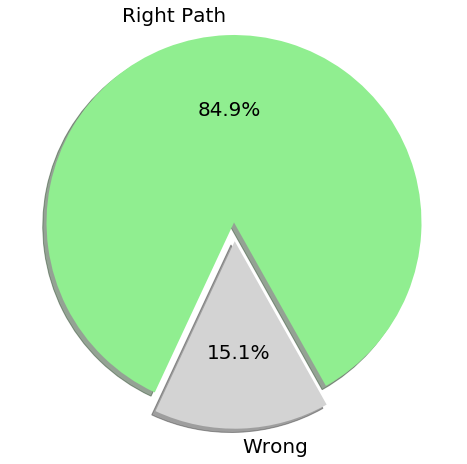

In [161]:
# Data to plot
labels = 'Wrong', 'Right Path'
sizes = [1-0.849, 0.849]
colors = ['lightgrey', 'lightgreen']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
fig = plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=-115,textprops={'fontsize': 20})
 
plt.axis('equal')
plt.show()

# how deep can the alg go?

In [ ]:
(4, 0.248), (5, 0.181), (2, 0.076), (1, 0.28), (3, 0.064)

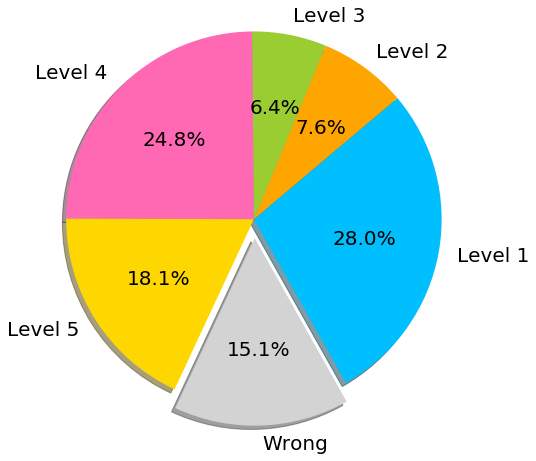

In [167]:
 
# Data to plot
labels = 'Wrong','Level 1', 'Level 2','Level 3','Level 4','Level 5'
sizes = [1-0.849, 0.28, 0.076, 0.064, 0.248, 0.181]
colors = ['lightgrey', 'deepskyblue','orange', 'yellowgreen','hotpink', 'gold']

explode = (0.1, 0,0,0,0,0)  # explode 1st slice
 
# Plot
fig = plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=-115,textprops={'fontsize': 20})
 
plt.axis('equal')
plt.show()

In [169]:
df_paths.shape

(16402, 10)

# how diff are the Predicted wrt Actual Levels?

In [133]:
np.sum([0.031, 0.005, 0.002])

0.038

In [143]:
cm.Set1(np.arange(8)/8.)

array([[0.89411765, 0.10196078, 0.10980392, 1.        ],
       [0.21568627, 0.49411765, 0.72156863, 1.        ],
       [0.30196078, 0.68627451, 0.29019608, 1.        ],
       [0.59607843, 0.30588235, 0.63921569, 1.        ],
       [1.        , 0.49803922, 0.        , 1.        ],
       [1.        , 1.        , 0.2       , 1.        ],
       [0.65098039, 0.3372549 , 0.15686275, 1.        ],
       [0.96862745, 0.50588235, 0.74901961, 1.        ]])

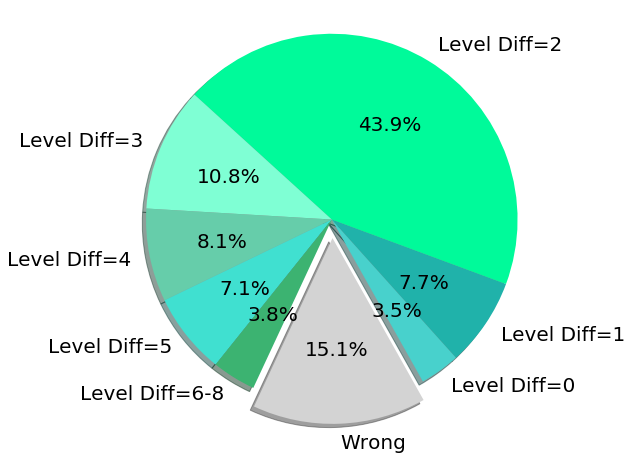

In [168]:
import matplotlib.pyplot as plt
from matplotlib import cm
# Data to plot
labels = 'Wrong','Level Diff=0', 'Level Diff=1','Level Diff=2','Level Diff=3','Level Diff=4',\
'Level Diff=5','Level Diff=6-8'
sizes = [1-0.849, 0.035, 0.077, 0.439, 0.108, 0.081, 0.071, 0.038]
colors = ['lightgrey','mediumturquoise','lightseagreen','mediumspringgreen','aquamarine',\
          'mediumaquamarine','turquoise','mediumseagreen']

#colors = cm.Set1(np.arange(8)/8.)
explode = (0.1, 0,0,0,0,0,0,0)  # explode 1st slice
 
# Plot
fig = plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=-115,textprops={'fontsize': 20})


plt.axis('equal')
plt.show()

In [170]:
df_paths.head()

,0,1,2,3,4,5,6,7,8,-1
0,Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dummy
1,Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dummy
2,Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dummy
3,Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dummy
4,Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dummy


# confustion matrix:

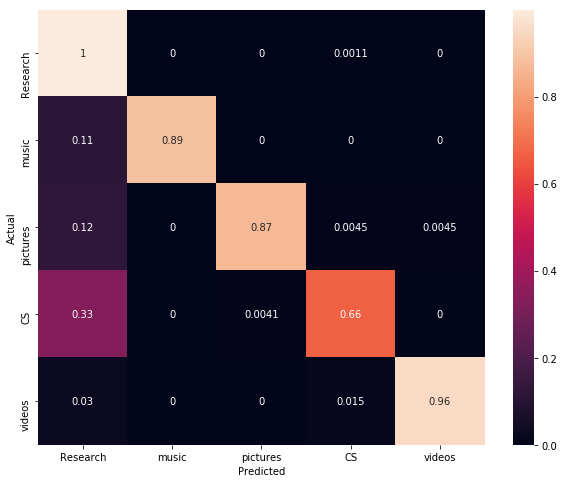

In [179]:
count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
                ngram_range=(1, 2), stop_words='english')

X_train_counts = count_vect.fit_transform(file_name_final)
features = X_train_counts.toarray()


categ_labels = list(df_paths[0].unique())


model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, df_paths[0], df_paths.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred,labels=categ_labels)
fig, ax = plt.subplots(figsize=(10,8))

#if normalize:
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=categ_labels, yticklabels=categ_labels)
sns.heatmap(conf_mat, annot=True,xticklabels=categ_labels, yticklabels=categ_labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [174]:
conf_mat 

array([[2740,    0,    0,    3,    0],
       [   1,    8,    0,    0,    0],
       [  27,    0,  192,    1,    1],
       [  80,    0,    1,  160,    0],
       [   2,    0,    0,    1,   64]])

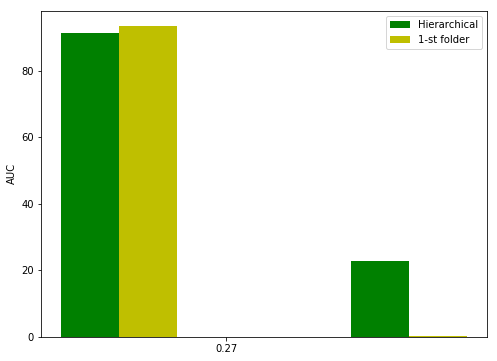

In [28]:
dist_hier = np.array([0.912, 0.227])*100
dist_flat = [93.4, 0.2]


x = np.array(range(len(dist_hier)))

y1 = dist_hier
y2 = dist_flat


fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)


ax.bar(x-0.2, y1,width=0.2,color='g',align='center')
ax.bar(x, y2,width=0.2,color='y',align='center')


ind = np.arange(1)  # the x locations for the groups
width = 0.27       # the width of the bars




ax.set_ylabel('AUC')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ind )
ax.legend( ('Hierarchical', '1-st folder') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
plt.show()

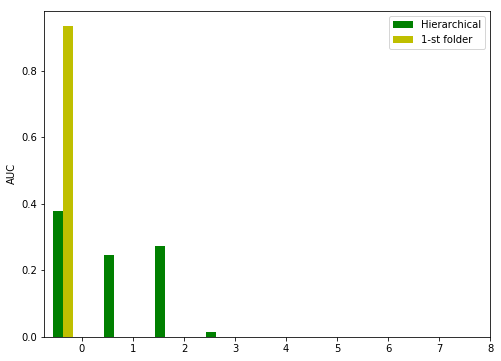

In [29]:
dist_hier = [0.379, 0.245, 0.274, 0.014] #(3, 0.274), (2, 0.245), (1, 0.379), (4, 0.014)
dist_flat = [0.934, 0, 0, 0]


x = np.array(range(len(dist_hier)))

y1 = dist_hier
y2 = dist_flat


fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)


ax.bar(x-0.2, y1,width=0.2,color='g',align='center')
ax.bar(x, y2,width=0.2,color='y',align='center')


ind = np.arange(9)  # the x locations for the groups
width = 0.27       # the width of the bars




ax.set_ylabel('AUC')
ax.set_xticks(ind+width)
ax.set_xticklabels( ind )
ax.legend( ('Hierarchical', '1-st folder') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
plt.show()

# difference between pred & actual levels

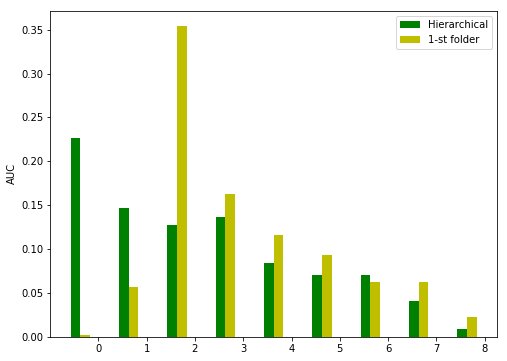

In [30]:
dist_hier = [0.227, 0.147, 0.127, 0.136, 0.084, 0.07, 0.07, 0.041, 0.009]
dist_flat = [0.002, 0.057, 0.354, 0.163, 0.116, 0.093, 0.063, 0.063, 0.023]


x = np.array(range(len(dist_hier)))

y1 = dist_hier
y2 = dist_flat


fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)


ax.bar(x-0.2, y1,width=0.2,color='g',align='center')
ax.bar(x, y2,width=0.2,color='y',align='center')


ind = np.arange(9)  # the x locations for the groups
width = 0.27       # the width of the bars




ax.set_ylabel('AUC')
ax.set_xticks(ind+width)
ax.set_xticklabels( ind )
ax.legend( ('Hierarchical', '1-st folder') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
plt.show()

# accumulated prob_total version for old data set 

In [31]:
# # accumulated prob_total version 

# for prob_threshold in np.linspace(0,1,11):
#     print(prob_threshold)
#     print('train_set:')
#     preds = Hierarchical_predict(X_train, prob_threshold)

#     Hierarchical_auc(preds, y_train)
#     print('test_set')
#     preds_test = Hierarchical_predict(X_test,prob_threshold)

#     Hierarchical_auc(preds_test, y_test)
#     print('\n')

# Non- accumulated prob_total version : Doesn't do as well as accumulated version


In [32]:
# # # non - accumulated prob_total version 
# for prob_threshold in np.linspace(0,1,11):
#     print(prob_threshold)
#     print('train_set:')
#     preds = Hierarchical_predict_non_accum(X_train, prob_threshold)

#     Hierarchical_auc(preds, y_train)
#     print('test_set')
#     preds_test = Hierarchical_predict_non_accum(X_test,prob_threshold)

#     Hierarchical_auc(preds_test, y_test)
#     print('\n')

In [33]:
# no stemming results:

0.0
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.385, 0.001, 0.13]
dict_items([(9, 0.385)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.343, 0.0, 0.145]
dict_items([(9, 0.343)])


0.1
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.403, 0.008, 0.149]
dict_items([(9, 0.383), (3, 0.006), (2, 0.013), (4, 0.001)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.37, 0.013, 0.172]
dict_items([(9, 0.343), (2, 0.023), (3, 0.004)])


0.2
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.514, 0.09, 0.264]
dict_items([(9, 0.347), (3, 0.049), (4, 0.01), (2, 0.107), (1, 0.001)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.46, 0.074, 0.26]
dict_items([(9, 0.326), (3, 0.034), (2, 0.091), (4, 0.006), (1, 0.002)])


0.30000000000000004
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.574, 0.099, 0.298]
dict_items([(1, 0.006), (9, 0.307), (3, 0.069), (2, 0.167), (4, 0.025)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.523, 0.085, 0.289]
dict_items([(9, 0.294), (2, 0.14), (3, 0.062), (4, 0.021), (1, 0.006)])


0.4
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.671, 0.109, 0.38]
dict_items([(1, 0.073), (4, 0.029), (9, 0.268), (3, 0.105), (2, 0.197)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.64, 0.098, 0.402]
dict_items([(9, 0.253), (2, 0.185), (1, 0.066), (3, 0.102), (4, 0.034)])


0.5
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.74, 0.106, 0.422]
dict_items([(1, 0.163), (4, 0.027), (9, 0.242), (2, 0.213), (3, 0.095)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.702, 0.102, 0.434]
dict_items([(9, 0.236), (1, 0.149), (2, 0.204), (3, 0.074), (4, 0.038)])


0.6000000000000001
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.784, 0.094, 0.429]
dict_items([(3, 0.099), (1, 0.219), (2, 0.264), (9, 0.182), (4, 0.019)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.749, 0.085, 0.44]
dict_items([(4, 0.028), (9, 0.185), (1, 0.204), (2, 0.247), (3, 0.085)])


0.7000000000000001
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.835, 0.11, 0.493]
dict_items([(2, 0.312), (1, 0.288), (3, 0.092), (9, 0.137), (4, 0.006)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.823, 0.109, 0.534]
dict_items([(3, 0.087), (9, 0.126), (1, 0.279), (2, 0.311), (4, 0.021)])


0.8
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.877, 0.135, 0.517]
dict_items([(2, 0.307), (1, 0.363), (3, 0.086), (4, 0.007), (9, 0.115)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.868, 0.119, 0.553]
dict_items([(2, 0.311), (1, 0.381), (3, 0.064), (4, 0.015), (9, 0.098)])


0.9
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.904, 0.093, 0.568]
dict_items([(1, 0.645), (2, 0.215), (3, 0.011), (9, 0.031), (4, 0.003)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.904, 0.079, 0.583]
dict_items([(2, 0.2), (1, 0.681), (9, 0.021), (3, 0.002)])


1.0
train_set:
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.92, 0.002, 0.591]
dict_items([(1, 0.92)])
test_set
Ratio of count_right_path Ratio of count_right_level Ratio of count_close_level [0.909, 0.002, 0.583]
dict_items([(1, 0.909)])

SyntaxError: invalid syntax (<ipython-input-33-bcbfcfe35034>, line 4)

**Hierarchical Classification**

In the **top-down approach**, in the training phase, the class hierarchy is processed one
level at a time, producing one or more classifiers for each class level. In the test phase,
each example is classified in a top-down fashion, as follows. 

First, the test example is assigned to one or more classes by the first-level classifier(s). 

Then the second level classifier(s) will assign to this example one or more sub-classes of the class(es) predicted
at the first level, and so on, until the example’s class(es) is(are) predicted at the deepest
possible level.

In order to produce a hierarchical set of classifiers in the top-down approach, we can
either train a single classifier per class level or train multiple classifiers per level. In the
former case, we use a multi-class classification algorithm. Thus, at each class level, we
build a classifier that predicts the class(es) of an example at that level. 

**Plan:**

At each node, build a classifier? And then save all the calssifiers?

# NO-hierarchical part

In [ ]:
# same as the part in the begining of this notebook

# data_split = list(map(lambda x: os.path.normpath(x).split(os.sep), data))
# data_drop_single = list(filter(lambda x: len(x)>1, data_split)) #change to len(x)>1 since solver needs >=2 classes!!!!
# file_name = list(map(lambda x: x[-1], data_drop_single))
# file_name_html = [html.unescape(x) for x in file_name]
# file_name_underscore = [x.lower().replace("_", " ") for x in file_name_html]
# file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
# file_name_final = [' '.join(x) for x in file_name_word_split]        

# #file_names_col = np.array(file_name_final).reshape(-1,1)


# file_labels = list(map(lambda x: x[:-1], data_drop_single))
# df_labels = pd.DataFrame(data = file_labels)
# df_paths = pd.DataFrame(data = df_labels[0])
# for i in range(1, df_labels.shape[1]):
#     df_paths[i] = df_labels[i]

#     df_paths.loc[pd.notna(df_labels[i]), i] = df_paths[i-1].map(str) + '/' + df_paths[i]
    
# df_paths.replace('None', np.nan, inplace=True)
# df_paths[-1] = 'dummy'
# df_paths = df_paths.astype('category', copy = False)



# feature Vectorizition

In [ ]:
# #TfidfVectorizer is Equivalent to CountVectorizer followed by TfidfTransformer.
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='latin-1', \
#                         ngram_range=(1, 2), stop_words='english') 
# features = tfidf.fit_transform(df.file_name).toarray()
# labels = df.main_folder
# features.shape

# equivalent:

In [ ]:
count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
                    ngram_range=(1, 2), stop_words='english')

X_train_counts = count_vect.fit_transform(file_name_final )
tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

features = X_train_tfidf.toarray()
labels = df_paths[0]
features.shape

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(file_name_final ).toarray()

# visualize output label

In [ ]:
N = 3
for category_id in df_paths[0].cat.categories.tolist():
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category_id))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}\n".format('\n. '.join(bigrams[-N:])))

# Model Selection Based on First Folder

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

# Confusin Matrix

In [ ]:
#model = LinearSVC()
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, labels, df_paths.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import confusion_matrix

categ_labels = df_paths[0].cat.categories.tolist()
conf_mat = confusion_matrix(y_test, y_pred,labels=categ_labels)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categ_labels, yticklabels=categ_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## fucntion for main folder prediction

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# import glob
# import random
# import string
# import html
# import re
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
# from sklearn.svm import LinearSVC
# import pickle


# def ModelIt(file_name_input, file_path_input):
#     model_train(file_path_input)
#     path_pred = model_predict(file_name_input)
#     return path_pred

# def model_train( file_path_input):

#     if file_path_input == '':
#         file_path_input = os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)) \
#         # the expression returns the full path name of the executing script in a multiplatform-safe way. 
# #         No need to hardwire any directions, that's why it is so useful.

#     root_dir = file_path_input
#     data = []
#     for filename in glob.iglob(root_dir + '**/*', recursive=True):
#          data.append(os.path.relpath(filename, root_dir))
#     #print(data)
#     data_split = list(map(lambda x: os.path.normpath(x).split(os.sep), data))
#     data_drop_single = list(filter(lambda x: len(x)>1, data_split))
#     file_name = list(map(lambda x: x[-1], data_drop_single))
#     file_name_html = [html.unescape(x) for x in file_name]
#     file_name_underscore = [x.replace("_", " ") for x in file_name_html]
#     file_name_word_split = [re.findall(r"[\w']+", x) for x in file_name_underscore]
#     file_name_final = [' '.join(x) for x in file_name_word_split]

#     data_first_folder = list(map(lambda x: x[0], data_drop_single))
#     data_1_folder = np.array([data_first_folder, file_name_final]).transpose()

#     df = pd.DataFrame(data = data_1_folder, columns=['main_folder', 'file_name'])
#     df.main_folder = df.main_folder.astype('category',copy=False)
#     df.file_name = df.file_name.astype('str', copy = False)
    
#     X_train = df['file_name']
#     y_train = df['main_folder']
#     count_vect = CountVectorizer(min_df=8, encoding='latin-1', \
#                         ngram_range=(1, 2), stop_words='english')
#     X_train_counts = count_vect.fit_transform(X_train)
#     tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

#     X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#     clf = LinearSVC(random_state=0)

#     clf.fit(X_train_tfidf, y_train)
#     #After fitting the training set, let’s make some predictions.
#     # put file_name inside a []

#     pickle.dump(clf, open('clf_folder_picker', 'wb'))
#     pickle.dump(count_vect, open('count_vect', 'wb'))
    
# def model_predict(file_name_input):
#     clf = pickle.load(open('clf_folder_picker', 'rb'))
#     count_vect = pickle.load(open('count_vect', 'rb'))
    
#     y_pred = clf.predict(count_vect.transform([file_name_input]))
   
#     # abs_file_path = os.path.join('/Users/wentingchen/Documents/',y_pred[0])
#     path_pred = y_pred[0]
#     return path_pred




In [ ]:
# ModelIt('summer.png', '/Users/wentingchen/Documents/Folder_Sample/')